In [1]:
%load_ext autoreload
%autoreload 2

from src.experiment import get_fallacy_df, RESPONSE_ERROR
from src.analysis import (
    get_sanity_check,
    add_identification_scores,
    get_macro_accuracies,
    add_llm_info,
    get_confusion_matrices,
    get_identification_confusion_metrics,
)
from src.plot import plot_accuracies, plot_identification_confusion_matrix, save_plot
from src.llms import LLM, LLMGroup
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

sns.set_theme()


# Fallacy Identification Analysis

## Dataset


In [2]:
df_fallacies_e1 = get_fallacy_df('data/fallacies_e1.csv')

df_fallacies_e1.head()

[2024-11-02 19:42:20] Loaded existing fallacy dataframe from data/fallacies_e1.csv.


,step,entity,fallacy,label,category,subcategory,gpt_4o_response,gpt_4_response,gpt_4o_mini_response,claude_3_5_sonnet_response,...,claude_3_haiku_response,gemini_1_5_pro_response,gemini_1_5_flash_response,gemini_1_5_flash_8b_response,llama_3_1_70b_response,llama_3_1_8b_response,mistral_large_2_response,mistral_small_2_response,o1_preview_response,o1_mini_response
0,Since John asked Maria if she used the last of...,tepas,Argument from Silence,1,informal,insufficiency,No.,No,No.,No,...,No.,No,No,No,No,No,No.,No.,No,No
1,Since Alice asked if Bob knew what an 'ossia' ...,ossia,Argument from Silence,1,informal,insufficiency,No.,No,No.,No,...,No.,No,No,No,No,No,No.,No.,No.,No
2,Since Alice claims that the Hausdorff contents...,hausdorff contents,Argument from Silence,1,informal,insufficiency,No.,No,No.,No,...,No.,No,No,No,No,No,No.,No.,No.,No
3,"Since Tom, a seasoned tugboater, said that ice...",tugboaters,Argument from Silence,1,informal,insufficiency,No.,No,No.,No,...,No.,Yes,No,No,No,No.,No.,No.,No.,No
4,Since John accuses Mary of being terrified of ...,beewolf,Argument from Silence,1,informal,insufficiency,No.,No,No.,No,...,No.,No,No,No,No,No,No.,No.,No.,No


In [3]:
df_fallacies_count = df_fallacies_e1.groupby(['category', 'subcategory'], observed=True).size().to_frame('count')
df_fallacies_count = df_fallacies_count.sort_values(by=['category', 'count'], ascending=[False, False]).reset_index()
df_fallacies_count

,category,subcategory,count
0,informal,irrelevance,1560
1,informal,insufficiency,1160
2,informal,inappropriate presumption,1080
3,informal,ambiguity,300
4,informal,inconsistency,60
5,formal,syllogistic,160
6,formal,propositional,120
7,formal,quantificational,120
8,formal,probabilistic,80


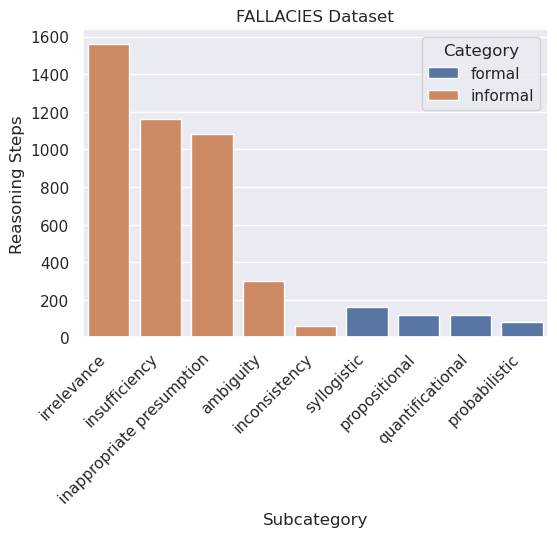

In [4]:
# Convert categorical column to get bar order right
df_fallacies_count['subcategory'] = df_fallacies_count['subcategory'].astype(str)

_, ax = plt.subplots(figsize=(6, 4))
sns.barplot(x='subcategory', y='count', data=df_fallacies_count, hue='category', ax=ax)
plt.xticks(rotation=45, ha='right')
title = 'FALLACIES Dataset'
plt.title(title)
plt.xlabel('Subcategory')
plt.ylabel('Reasoning Steps')
plt.legend(title='Category')

save_plot(title)
plt.show()

- The FALLACIES dataset contains 4640 reasoning steps, divided into 232 different fallacy types.
- For each fallacy type, there are 10 correct and 10 incorrect reasoning steps.
- The fallacy types are grouped into 4 formal and 5 informal subcategories.
- There are more informal than formal fallacy types.
- To account for category and subcategory imbalance, the accuracies are based on macro-averaging.


## Experiment 1: Fallacy Identification with zero-shot Prompt

In [5]:
df_fallacies_e1 = get_fallacy_df('data/fallacies_e1.csv')

# o1-preview was aborted due to high cost
df_fallacies_e1 = df_fallacies_e1.drop(columns='o1_preview_response')

[2024-11-02 19:42:21] Loaded existing fallacy dataframe from data/fallacies_e1.csv.


### Scoring and Sanity Check

In [6]:
add_identification_scores(df_fallacies_e1)

df_fallacies_e1.head()

,step,entity,fallacy,label,category,subcategory,gpt_4o_response,gpt_4_response,gpt_4o_mini_response,claude_3_5_sonnet_response,...,gemini_1_5_flash_8b_pred,gemini_1_5_flash_8b_score,llama_3_1_70b_pred,llama_3_1_70b_score,llama_3_1_8b_pred,llama_3_1_8b_score,mistral_large_2_pred,mistral_large_2_score,mistral_small_2_pred,mistral_small_2_score
0,Since John asked Maria if she used the last of...,tepas,Argument from Silence,1,informal,insufficiency,No.,No,No.,No,...,1,1,1,1,1,1,1,1,1,1
1,Since Alice asked if Bob knew what an 'ossia' ...,ossia,Argument from Silence,1,informal,insufficiency,No.,No,No.,No,...,1,1,1,1,1,1,1,1,1,1
2,Since Alice claims that the Hausdorff contents...,hausdorff contents,Argument from Silence,1,informal,insufficiency,No.,No,No.,No,...,1,1,1,1,1,1,1,1,1,1
3,"Since Tom, a seasoned tugboater, said that ice...",tugboaters,Argument from Silence,1,informal,insufficiency,No.,No,No.,No,...,1,1,1,1,1,1,1,1,1,1
4,Since John accuses Mary of being terrified of ...,beewolf,Argument from Silence,1,informal,insufficiency,No.,No,No.,No,...,1,1,1,1,1,1,1,1,1,1


In [7]:
# Check completeness of responses, predictions and scores
df_fallacies_e1.replace(['', RESPONSE_ERROR], None).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4640 entries, 0 to 4639
Data columns (total 48 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   step                          4640 non-null   object  
 1   entity                        4640 non-null   object  
 2   fallacy                       4640 non-null   category
 3   label                         4640 non-null   category
 4   category                      4640 non-null   category
 5   subcategory                   4640 non-null   category
 6   gpt_4o_response               4640 non-null   object  
 7   gpt_4_response                4640 non-null   object  
 8   gpt_4o_mini_response          4640 non-null   object  
 9   claude_3_5_sonnet_response    4640 non-null   object  
 10  claude_3_opus_response        4640 non-null   object  
 11  claude_3_haiku_response       4640 non-null   object  
 12  gemini_1_5_pro_response       4640 non-null   ob

In [8]:
get_sanity_check(df_fallacies_e1)

,response_length_mean,missing_responses,invalid_predictions
gpt_4o,3.3,0,0
gpt_4,2.5,0,0
gpt_4o_mini,3.4,0,0
claude_3_5_sonnet,2.4,0,0
claude_3_opus,3.2,0,0
claude_3_haiku,3.3,0,0
gemini_1_5_pro,2.5,0,0
gemini_1_5_flash,2.4,0,0
gemini_1_5_flash_8b,2.4,0,0
llama_3_1_70b,2.7,0,1


### Global Accuracies

In [9]:
_, df_subcategory_accuracies_e1, df_category_accuracies_e1, df_global_accuracies_e1 = get_macro_accuracies(df_fallacies_e1)

In [10]:
df_global_accuracies_e1 = df_global_accuracies_e1.sort_values('accuracy', ascending=False)
df_global_accuracies_e1

,accuracy
gpt_4,88.139394
gemini_1_5_pro,87.137212
gpt_4o,86.775211
o1_mini,85.851212
claude_3_opus,83.946236
claude_3_5_sonnet,83.764299
gpt_4o_mini,83.049186
llama_3_1_70b,82.953173
gemini_1_5_flash,82.152709
gemini_1_5_flash_8b,81.283724


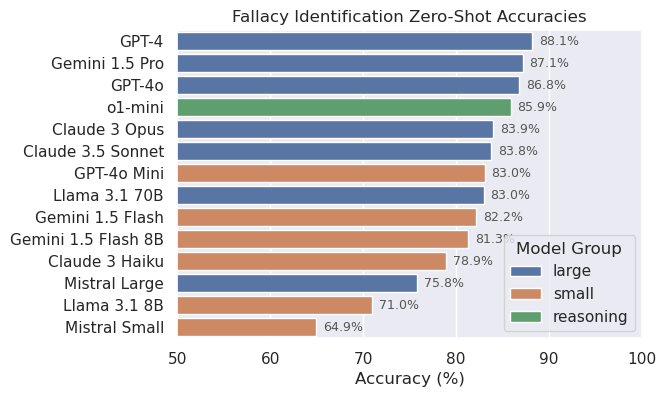

In [67]:
plot_accuracies(
    data=add_llm_info(df_global_accuracies_e1),
    figsize=(6, 4),
    title='Fallacy Identification Zero-Shot Accuracies',
    hue='llm_group',
    hue_order=[group.value for group in [LLMGroup.LARGE, LLMGroup.SMALL, LLMGroup.REASONING]],
    legend_title='Model Group',
    annotate=True,
    xlim=(50, 100),
)

- GPT-4 still performs best, despite being a relatively outdated model. The global accuracy of 88.1% is very close to the 87.7% obtained by Hong et al. (2024).
- The flagship models GPT-4, Gemini 1.5 Pro, and Claude 3.5 Sonnet perform similarly.
- The small models fall off in accuracy, but still achieve better results than the weaker models in the study by Hong et al. (2024).

### Fallacy Category Accuracies

In [12]:
df_category_accuracies_e1

category,formal,informal
gpt_4,88.125,88.153787
gpt_4o,85.416667,88.133756
gpt_4o_mini,79.010417,87.087956
o1_mini,85.989583,85.71284
claude_3_5_sonnet,85.0,82.528598
claude_3_opus,84.791667,83.100806
claude_3_haiku,75.677083,82.207172
gemini_1_5_pro,87.552083,86.72234
gemini_1_5_flash,81.614583,82.690834
gemini_1_5_flash_8b,78.854167,83.713282


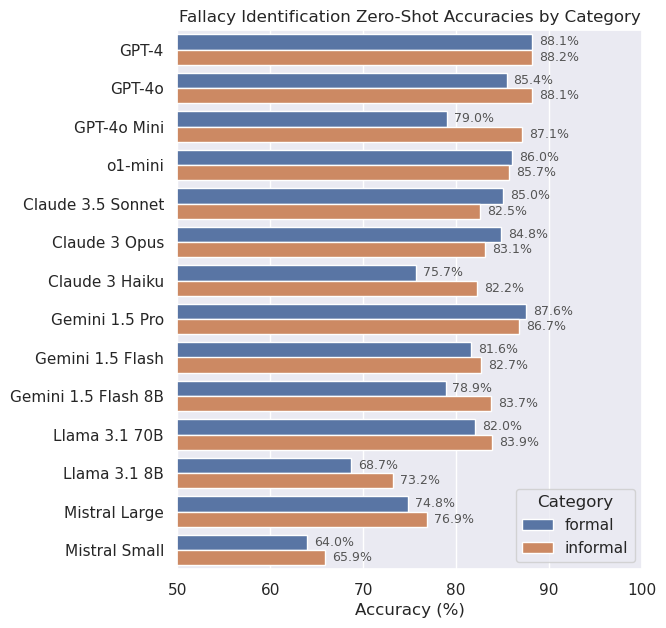

In [13]:
df_category_accuracies_long_e1 = pd.melt(df_category_accuracies_e1, var_name='category', value_name='accuracy',
                                         ignore_index=False)
plot_accuracies(
    data=add_llm_info(df_category_accuracies_long_e1),
    figsize=(6, 7),
    title='Fallacy Identification Zero-Shot Accuracies by Category',
    hue='category',
    legend_title='Category',
    annotate=True,
    xlim=(50, 100),
)

- Lightweight models like GPT-4o Mini, Claude 3 Haiku, and Gemini 1.5 Flash 8B perform worse on formal compared to informal fallacy identification. This replicates the findings by Hong et al. (2024).
- The flagship models perform similarly on formal and informal fallacy identification.

In [14]:
df_plot = add_llm_info(df_category_accuracies_long_e1, group=True).groupby(['llm_group', 'category'], observed=True).mean().reset_index()
df_plot

,llm_group,category,accuracy
0,large,formal,83.958333
1,large,informal,84.1972
2,reasoning,formal,85.989583
3,reasoning,informal,85.71284
4,small,formal,74.635417
5,small,informal,79.141442


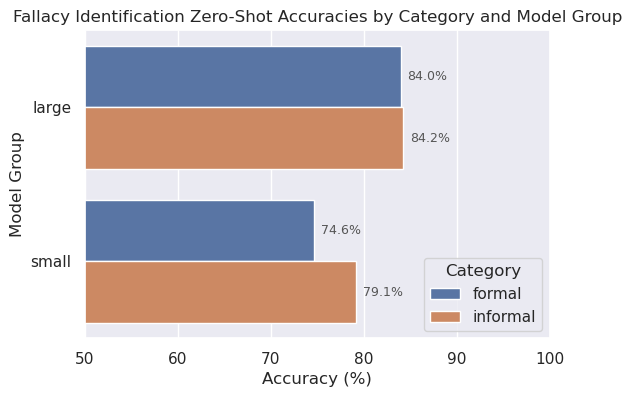

In [15]:
plot_accuracies(
    data=df_plot,
    figsize=(6, 4),
    title='Fallacy Identification Zero-Shot Accuracies by Category and Model Group',
    y='llm_group',
    y_label='Model Group',
    hue='category',
    legend_title='Category',
    order=[group.value for group in [LLMGroup.LARGE, LLMGroup.SMALL]],
    annotate=True,
    xlim=(50, 100),
)

- When grouping the LLMs into large and small models, the underperformance of small models on formal fallacies becomes more apparent.

### Fallacy Subcategory Accuracies

In [16]:
df_subcategory_accuracies_e1

category                   formal                                             \
subcategory         probabilistic propositional quantificational syllogistic   
gpt_4                       86.25     93.333333        84.166667       88.75   
gpt_4o                       87.5     83.333333        80.833333        90.0   
gpt_4o_mini                  77.5          80.0        74.166667      84.375   
o1_mini                      82.5     88.333333             82.5      90.625   
claude_3_5_sonnet           81.25     86.666667        80.833333       91.25   
claude_3_opus               83.75          85.0        86.666667       83.75   
claude_3_haiku              78.75     69.166667        74.166667      80.625   
gemini_1_5_pro              88.75          85.0        85.833333      90.625   
gemini_1_5_flash            76.25     81.666667        81.666667      86.875   
gemini_1_5_flash_8b         76.25          77.5        76.666667        85.0   
llama_3_1_70b                82.5          77.5             85.0      83.125   
llama_3_1_8b                68.75          67.5        71.666667      66.875   
mistral_large_2             71.25          67.5        76.666667       83.75   
mistral_small_2              67.5     55.833333             65.0        67.5   

category              informal                                          \
subcategory          ambiguity inappropriate presumption inconsistency   
gpt_4                84.666667                 86.944444          85.0   
gpt_4o                    85.0                 87.037037     88.333333   
gpt_4o_mini          84.333333                 87.037037     86.666667   
o1_mini              78.333333                 85.462963          85.0   
claude_3_5_sonnet    78.666667                 84.259259     81.666667   
claude_3_opus             82.0                 83.981481     83.333333   
claude_3_haiku            81.0                 83.148148     78.333333   
gemini_1_5_pro       85.666667                 88.055556          80.0   
gemini_1_5_flash          80.0                 84.444444     81.666667   
gemini_1_5_flash_8b  81.666667                  84.62963     81.666667   
llama_3_1_70b        83.666667                 84.444444          80.0   
llama_3_1_8b         69.333333                 76.574074          65.0   
mistral_large_2           74.0                 77.222222     78.333333   
mistral_small_2      63.333333                 66.296296          65.0   

category                                       
subcategory         insufficiency irrelevance  
gpt_4                   93.965517   90.192308  
gpt_4o                  92.413793   87.884615  
gpt_4o_mini              91.12069   86.282051  
o1_mini                 90.344828   89.423077  
claude_3_5_sonnet       86.896552   81.153846  
claude_3_opus           86.637931   79.551282  
claude_3_haiku          85.862069   82.692308  
gemini_1_5_pro          92.068966   87.820513  
gemini_1_5_flash        86.637931   80.705128  
gemini_1_5_flash_8b     88.103448        82.5  
llama_3_1_70b           87.931034   83.333333  
llama_3_1_8b            80.344828   74.935897  
mistral_large_2          78.62069   76.153846  
mistral_small_2         66.724138   68.205128

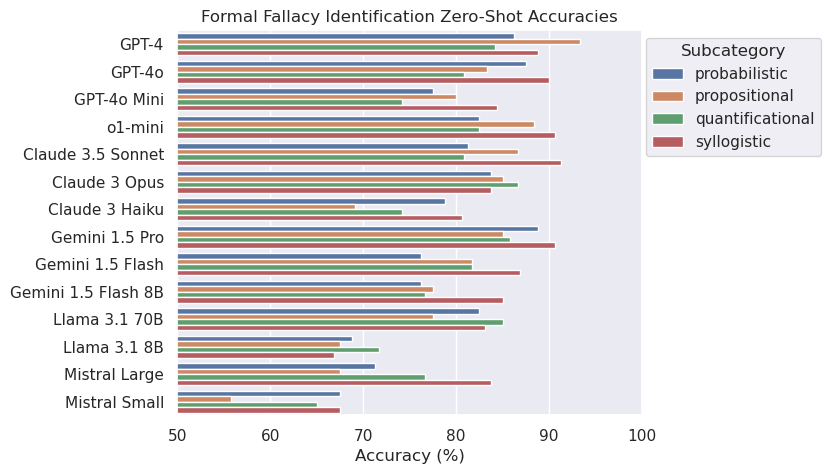

In [17]:
df_subcategory_accuracies_long_e1 = pd.melt(df_subcategory_accuracies_e1, value_name='accuracy', ignore_index=False)
df_formal_accuracies_long_e1 = df_subcategory_accuracies_long_e1[
    df_subcategory_accuracies_long_e1['category'] == 'formal']

plot_accuracies(
    data=add_llm_info(df_formal_accuracies_long_e1),
    figsize=(6, 5),
    title='Formal Fallacy Identification Zero-Shot Accuracies',
    hue='subcategory',
    legend_title='Subcategory',
    legend_loc='upper right',
    legend_anchor=(1.4, 1),
    annotate=False,
    xlim=(50, 100),
)

In [18]:
df_plot = add_llm_info(df_formal_accuracies_long_e1, group=True).groupby(['llm_group', 'category', 'subcategory'], observed=True).mean().reset_index()
df_plot

,llm_group,category,subcategory,accuracy
0,large,formal,probabilistic,83.035714
1,large,formal,propositional,82.619048
2,large,formal,quantificational,82.857143
3,large,formal,syllogistic,87.321429
4,reasoning,formal,probabilistic,82.5
5,reasoning,formal,propositional,88.333333
6,reasoning,formal,quantificational,82.5
7,reasoning,formal,syllogistic,90.625
8,small,formal,probabilistic,74.166667
9,small,formal,propositional,71.944444


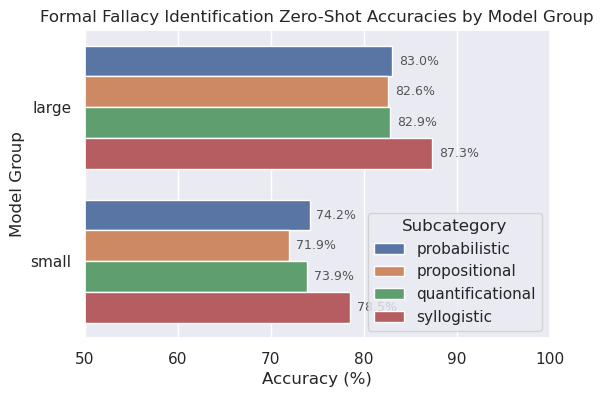

In [19]:
plot_accuracies(
    data=df_plot,
    figsize=(6, 4),
    title='Formal Fallacy Identification Zero-Shot Accuracies by Model Group',
    y='llm_group',
    y_label='Model Group',
    hue='subcategory',
    # order=[group.value for group in [LLMGroup.FLAGSHIP, LLMGroup.MEDIUM, LLMGroup.LIGHTWEIGHT]],
    order=[group.value for group in [LLMGroup.LARGE, LLMGroup.SMALL]],
    legend_title='Subcategory',
    annotate=True,
    xlim=(50, 100),
)

- The large LLMs perform well on all formal fallacy subcategories.
- The small LLMs perform well on syllogistic formal fallacies, but fall off for the other subcategories.

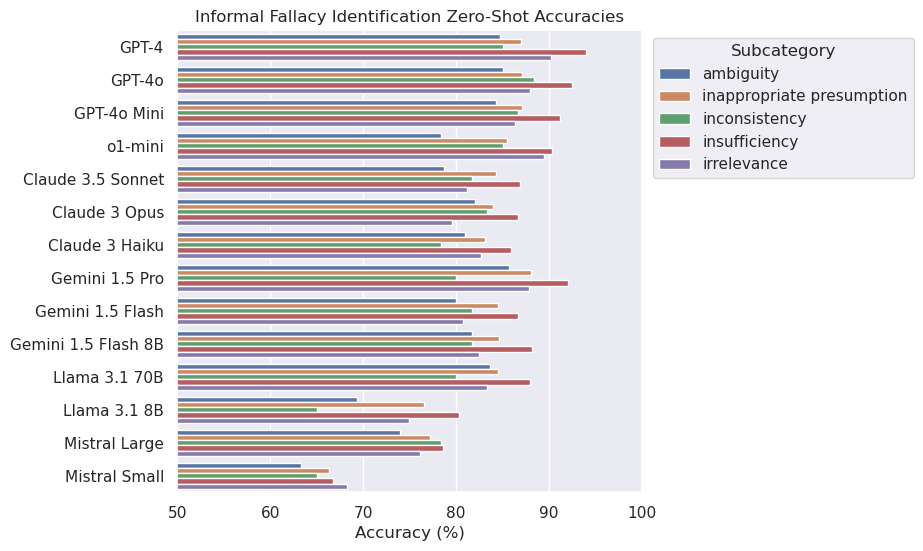

In [20]:
df_informal_accuracies_long_e1 = df_subcategory_accuracies_long_e1[
    df_subcategory_accuracies_long_e1['category'] == 'informal']

plot_accuracies(
    data=add_llm_info(df_informal_accuracies_long_e1),
    figsize=(6, 6),
    title='Informal Fallacy Identification Zero-Shot Accuracies',
    hue='subcategory',
    legend_title='Subcategory',
    legend_loc='upper right',
    legend_anchor=(1.6, 1),
    annotate=False,
    xlim=(50, 100),
)

In [21]:
df_plot = add_llm_info(df_informal_accuracies_long_e1, group=True).groupby(['llm_group', 'category', 'subcategory'], observed=True).mean().reset_index()
df_plot

,llm_group,category,subcategory,accuracy
0,large,informal,ambiguity,81.952381
1,large,informal,inappropriate presumption,84.563492
2,large,informal,inconsistency,82.380952
3,large,informal,insufficiency,88.362069
4,large,informal,irrelevance,83.727106
5,reasoning,informal,ambiguity,78.333333
6,reasoning,informal,inappropriate presumption,85.462963
7,reasoning,informal,inconsistency,85.0
8,reasoning,informal,insufficiency,90.344828
9,reasoning,informal,irrelevance,89.423077


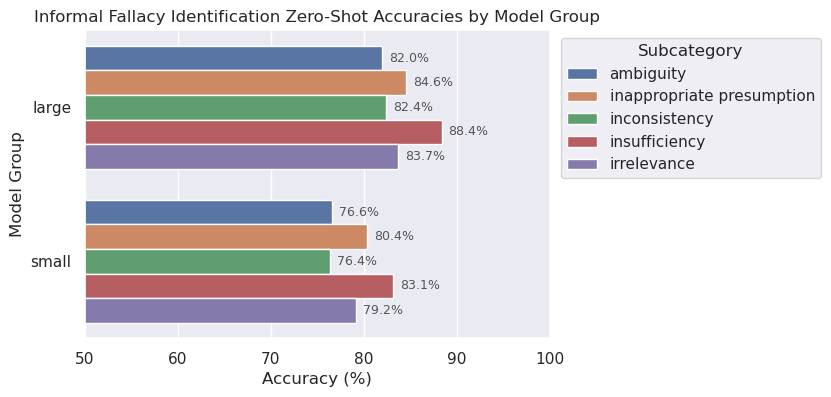

In [22]:
plot_accuracies(
    data=df_plot,
    figsize=(6, 4),
    title='Informal Fallacy Identification Zero-Shot Accuracies by Model Group',
    y='llm_group',
    y_label='Model Group',
    hue='subcategory',
    # order=[group.value for group in [LLMGroup.FLAGSHIP, LLMGroup.MEDIUM, LLMGroup.LIGHTWEIGHT]],
    order=[group.value for group in [LLMGroup.LARGE, LLMGroup.SMALL]],
    legend_title='Subcategory',
    legend_loc='upper right',
    legend_anchor=(1.6, 1),
    annotate=True,
    xlim=(50, 100),
)

- For informal fallacies, the small LLMs perform a bit worse on all subcategories compared to the large LLMs, but they show the same pattern.
- The LLMs perform best for insufficiency fallacies (the premises are insufficient or weak to support the conclusion).

### Confusion Analysis: Large vs. Small Models



In [23]:
df_confusion_e1 = get_confusion_matrices(df_fallacies_e1, 'label')

In [24]:
df_confusion_metrics_llm_e1 = get_identification_confusion_metrics(df_confusion_e1, ['llm', 'label'])
df_confusion_metrics_llm_e1.round(3)


,TP,FN,FP,TN,Accuracy,Precision,Recall,F1,McNemar-P
llm,,,,,,,,,
claude_3_5_sonnet,2209,111,648,1672,0.836,0.773,0.952,0.853,0.000
claude_3_haiku,2203,117,685,1635,0.827,0.763,0.950,0.846,0.000
claude_3_opus,2191,129,655,1665,0.831,0.770,0.944,0.848,0.000
gemini_1_5_flash,2159,161,618,1702,0.832,0.777,0.931,0.847,0.000
gemini_1_5_flash_8b,2133,187,554,1766,0.840,0.794,0.919,0.852,0.000
gemini_1_5_pro,2090,230,295,2025,0.887,0.876,0.901,0.888,0.005
gpt_4,2017,303,172,2148,0.898,0.921,0.869,0.895,0.000
gpt_4o,2031,289,249,2071,0.884,0.891,0.875,0.883,0.093
gpt_4o_mini,2086,234,376,1944,0.869,0.847,0.899,0.872,0.000


- Note that the accuracies differ from the macro-averaged accuracies, as the confusion matrix is calculated on the level of individual reasoning steps.

In [25]:
df_confusion_metrics_group_e1 = get_identification_confusion_metrics(df_confusion_e1, ['llm_group', 'label'])
df_confusion_metrics_group_e1.round(3)

,TP,FN,FP,TN,Accuracy,Precision,Recall,F1,McNemar-P
llm_group,,,,,,,,,
large,14984,1256,3612,12627,0.850,0.806,0.923,0.860,0.000
reasoning,2013,299,260,2055,0.879,0.886,0.871,0.878,0.108
small,13142,778,4840,9080,0.798,0.731,0.944,0.824,0.000


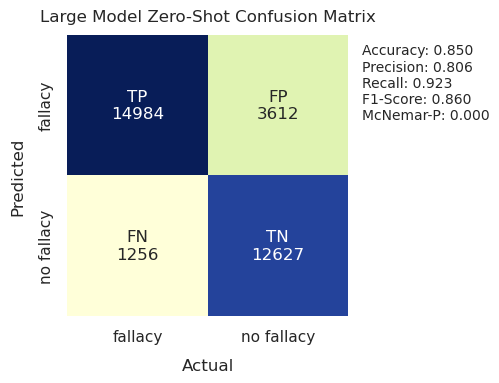

In [26]:
plot_identification_confusion_matrix(
    df_confusion_metrics_group_e1.loc[LLMGroup.LARGE.value], 
    title='Large Model Zero-Shot Confusion Matrix',
    figsize=(5, 4),
)

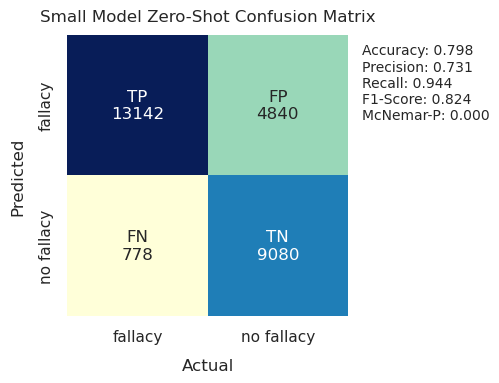

In [27]:
plot_identification_confusion_matrix(
    df_confusion_metrics_group_e1.loc[LLMGroup.SMALL.value], 
    title='Small Model Zero-Shot Confusion Matrix',
    figsize=(5, 4),
)

- The best models have about the same number of false positives and negatives 
- Small models have more false positives (judge valid reasoning as invalid)


### Confusion Analysis: Best vs. Worst Model

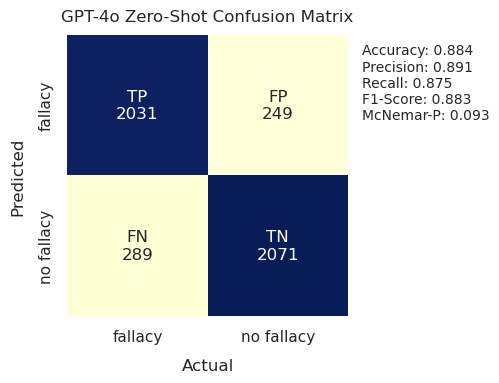

In [28]:
plot_identification_confusion_matrix(
    df_confusion_metrics_llm_e1.loc[LLM.GPT_4O.key], 
    title=f'{LLM.GPT_4O.label} Zero-Shot Confusion Matrix',
    figsize=(5, 4),
)

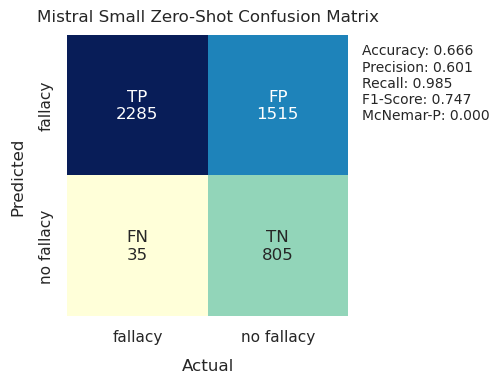

In [29]:
plot_identification_confusion_matrix(
    df_confusion_metrics_llm_e1.loc[LLM.MISTRAL_SMALL_2.key], 
    title=f'{LLM.MISTRAL_SMALL_2.label} Zero-Shot Confusion Matrix',
    figsize=(5, 4),
)

### Confusion Analysis: Fallacy Type Accuracies

In [30]:
df_confusion_metrics_fallacy = get_identification_confusion_metrics(df_confusion_e1, ['category', 'subcategory', 'fallacy', 'label'])
df_confusion_metrics_fallacy = df_confusion_metrics_fallacy.sort_values('F1', ascending=False).reset_index()

In [31]:
df_confusion_metrics_fallacy.head(10).round(3)

,category,subcategory,fallacy,TP,FN,FP,TN,Accuracy,Precision,Recall,F1,McNemar-P
0,informal,inappropriate presumption,Historians Fallacy,140,0,2,138,0.993,0.986,1.000,0.993,0.500
1,informal,irrelevance,Appeal to Complexity,140,0,4,136,0.986,0.972,1.000,0.986,0.125
2,informal,insufficiency,Confusing Currently Unexplained with Unexplain...,140,0,7,133,0.975,0.952,1.000,0.976,0.016
3,informal,insufficiency,Texas Sharpshooter Fallacy,140,0,11,129,0.961,0.927,1.000,0.962,0.001
4,informal,insufficiency,Hasty Generalization,140,0,13,127,0.954,0.915,1.000,0.956,0.000
5,informal,inappropriate presumption,Argument from Incredulity,140,0,13,127,0.954,0.915,1.000,0.956,0.000
6,informal,insufficiency,Slippery Slope,139,0,13,126,0.953,0.914,1.000,0.955,0.000
7,informal,inappropriate presumption,Argument to Moderation,137,3,10,130,0.954,0.932,0.979,0.955,0.092
8,informal,inappropriate presumption,Willed Ignorance,139,1,13,127,0.950,0.914,0.993,0.952,0.002
9,informal,insufficiency,Overwhelming Exception,136,4,10,130,0.950,0.932,0.971,0.951,0.180


- These are the fallacy types with the highest F1 scores.

In [32]:
df_confusion_metrics_fallacy.tail(10).round(3)

,category,subcategory,fallacy,TP,FN,FP,TN,Accuracy,Precision,Recall,F1,McNemar-P
222,informal,irrelevance,Traitorous Critic Fallacy,63,77,16,124,0.668,0.797,0.450,0.575,0.000
223,informal,inappropriate presumption,Rationalization,75,65,47,93,0.600,0.615,0.536,0.573,0.108
224,informal,inappropriate presumption,Argument by Repetition,70,70,62,78,0.529,0.530,0.500,0.515,0.543
225,informal,inappropriate presumption,Limited Scope,58,82,36,104,0.579,0.617,0.414,0.496,0.000
226,informal,inappropriate presumption,Circular Definition,48,92,15,125,0.618,0.762,0.343,0.473,0.000
227,formal,quantificational,Existential Fallacy,42,98,31,109,0.539,0.575,0.300,0.394,0.000
228,formal,syllogistic,Illicit Substitution of Identicals,36,104,30,110,0.521,0.545,0.257,0.350,0.000
229,informal,insufficiency,Stereotyping the fallacy,33,107,30,110,0.511,0.524,0.236,0.325,0.000
230,informal,ambiguity,Modal Scope Fallacy,28,112,14,126,0.550,0.667,0.200,0.308,0.000
231,informal,irrelevance,Having Your Cake,29,111,34,106,0.482,0.460,0.207,0.286,0.000


## Experiment 2: Fallacy Identification with few-shot Prompt

In [33]:
df_fallacies_e2 = get_fallacy_df('data/fallacies_e2.csv')

[2024-11-02 19:42:40] Loaded existing fallacy dataframe from data/fallacies_e2.csv.


### Scoring and Sanity Check

In [34]:
add_identification_scores(df_fallacies_e2)

df_fallacies_e2.head()

,step,entity,fallacy,label,category,subcategory,gpt_4o_response,claude_3_5_sonnet_response,gemini_1_5_pro_response,gpt_4o_mini_response,...,gemini_1_5_flash_8b_pred,gemini_1_5_flash_8b_score,llama_3_1_70b_pred,llama_3_1_70b_score,llama_3_1_8b_pred,llama_3_1_8b_score,mistral_large_2_pred,mistral_large_2_score,mistral_small_2_pred,mistral_small_2_score
0,Since John asked Maria if she used the last of...,tepas,Argument from Silence,1,informal,insufficiency,No.,No.,No.,No.,...,1,1,1,1,1,1,1,1,1,1
1,Since Alice asked if Bob knew what an 'ossia' ...,ossia,Argument from Silence,1,informal,insufficiency,No.,No.,No.,No.,...,1,1,1,1,1,1,1,1,1,1
2,Since Alice claims that the Hausdorff contents...,hausdorff contents,Argument from Silence,1,informal,insufficiency,No.,No.,No.,No.,...,1,1,1,1,1,1,1,1,1,1
3,"Since Tom, a seasoned tugboater, said that ice...",tugboaters,Argument from Silence,1,informal,insufficiency,No.,No.,Yes.,No.,...,1,1,0,0,1,1,NaN,0,1,1
4,Since John accuses Mary of being terrified of ...,beewolf,Argument from Silence,1,informal,insufficiency,No.,No.,No.,No.,...,1,1,1,1,1,1,1,1,1,1


In [35]:
# Check completeness of responses, predictions and scores
df_fallacies_e2.replace(['', RESPONSE_ERROR], None).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4640 entries, 0 to 4639
Data columns (total 39 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   step                          4640 non-null   object  
 1   entity                        4640 non-null   object  
 2   fallacy                       4640 non-null   category
 3   label                         4640 non-null   category
 4   category                      4640 non-null   category
 5   subcategory                   4640 non-null   category
 6   gpt_4o_response               4640 non-null   object  
 7   claude_3_5_sonnet_response    4640 non-null   object  
 8   gemini_1_5_pro_response       4640 non-null   object  
 9   gpt_4o_mini_response          4640 non-null   object  
 10  claude_3_haiku_response       4640 non-null   object  
 11  gemini_1_5_flash_response     4640 non-null   object  
 12  gemini_1_5_flash_8b_response  4640 non-null   ob

In [36]:
get_sanity_check(df_fallacies_e2)

,response_length_mean,missing_responses,invalid_predictions
gpt_4o,3.7,0,9
claude_3_5_sonnet,3.4,0,0
gemini_1_5_pro,3.5,0,4
gpt_4o_mini,3.5,0,0
claude_3_haiku,3.7,0,63
gemini_1_5_flash,3.0,0,218
gemini_1_5_flash_8b,2.5,0,1
llama_3_1_70b,3.0,0,52
llama_3_1_8b,4.3,0,23
mistral_large_2,8.8,0,1241


- Weaker LLMs had some issues with the few-shot prompts, responding with "Yes No No Yes Yes" sometimes.
- Mistral Large responded "Yes. No. No. Yes. Yes." 1241 times, and accuracy cannot be reliably determined. This model is therefore excluded from the analysis.

In [37]:
df_fallacies_e2.drop(columns=LLM.MISTRAL_LARGE_2.key + '_score' , inplace=True)

### Global Accuracies

In [38]:
_, df_subcategory_accuracies_e2, df_category_accuracies_e2, df_global_accuracies_e2 = get_macro_accuracies(df_fallacies_e2)

In [39]:
df_global_accuracies_e2 = df_global_accuracies_e2.sort_values('accuracy', ascending=False)
df_global_accuracies_e2

,accuracy
gemini_1_5_pro,85.684072
gpt_4o,85.421126
claude_3_5_sonnet,85.39816
gpt_4o_mini,84.163461
llama_3_1_70b,81.705942
gemini_1_5_flash_8b,77.53575
llama_3_1_8b,75.410476
gemini_1_5_flash,72.702111
mistral_small_2,72.124162
claude_3_haiku,71.22162


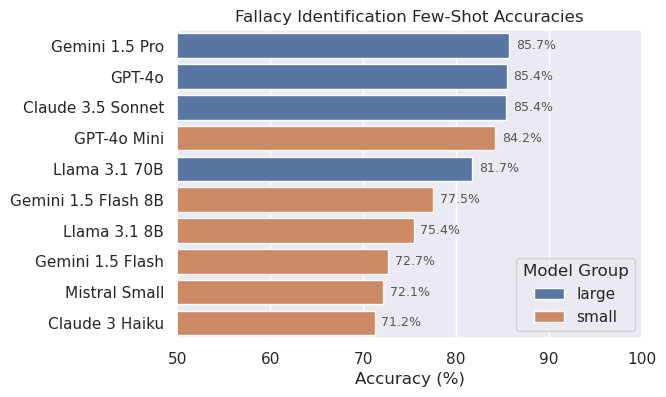

In [40]:
plot_accuracies(
    data=add_llm_info(df_global_accuracies_e2),
    figsize=(6, 4),
    title='Fallacy Identification Few-Shot Accuracies',
    hue='llm_group',
    hue_order=[group.value for group in [LLMGroup.LARGE, LLMGroup.SMALL]],
    legend_title='Model Group',
    annotate=True,
    xlim=(50, 100),
)


- Mistral Large responded "Yes. No. No. Yes. Yes." hundreds of times, which explains the low accuracy.

### Fallacy Category Accuracies

In [41]:
df_category_accuracies_e2

category,formal,informal
gpt_4o,84.791667,86.050585
gpt_4o_mini,81.979167,86.347755
claude_3_5_sonnet,85.78125,85.01507
claude_3_haiku,69.583333,72.859908
gemini_1_5_pro,84.947917,86.420228
gemini_1_5_flash,71.458333,73.945889
gemini_1_5_flash_8b,76.302083,78.769417
llama_3_1_70b,78.489583,84.922301
llama_3_1_8b,68.854167,81.966785
mistral_small_2,69.166667,75.081658


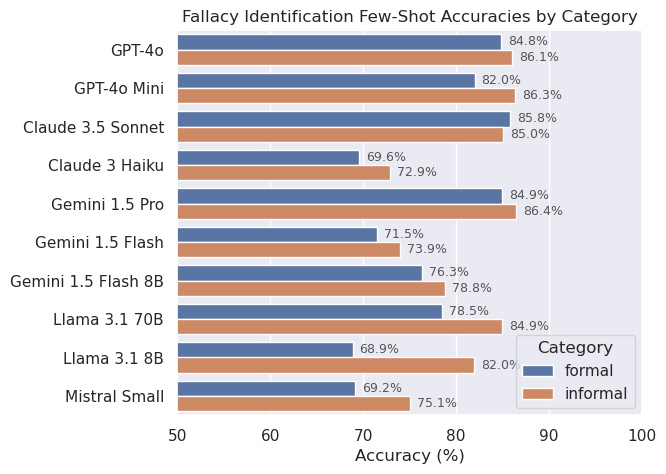

In [42]:
df_category_accuracies_long_e2 = pd.melt(df_category_accuracies_e2, var_name='category', value_name='accuracy', ignore_index=False)

plot_accuracies(
    data=add_llm_info(df_category_accuracies_long_e2),
    figsize=(6, 5),
    title='Fallacy Identification Few-Shot Accuracies by Category',
    hue='category',
    legend_title='Category',
    annotate=True,
    xlim=(50, 100),
)

### Fallacy Subcategory Accuracies

In [43]:
df_subcategory_accuracies_e2

category                   formal                                             \
subcategory         probabilistic propositional quantificational syllogistic   
gpt_4o                       87.5          85.0        76.666667        90.0   
gpt_4o_mini                 76.25     88.333333        75.833333        87.5   
claude_3_5_sonnet            85.0          82.5             85.0      90.625   
claude_3_haiku               70.0     60.833333             70.0        77.5   
gemini_1_5_pro              86.25     83.333333        83.333333      86.875   
gemini_1_5_flash            71.25          62.5        68.333333       83.75   
gemini_1_5_flash_8b          75.0          72.5        73.333333      84.375   
llama_3_1_70b               86.25          65.0        80.833333      81.875   
llama_3_1_8b                 67.5     70.833333        65.833333       71.25   
mistral_small_2              70.0     59.166667             70.0        77.5   

category              informal                                          \
subcategory          ambiguity inappropriate presumption inconsistency   
gpt_4o               84.666667                 86.481481     83.333333   
gpt_4o_mini          84.333333                 87.314815     81.666667   
claude_3_5_sonnet         83.0                 84.259259     88.333333   
claude_3_haiku       73.333333                 74.074074     71.666667   
gemini_1_5_pro            85.0                  85.37037     83.333333   
gemini_1_5_flash          74.0                      72.5          75.0   
gemini_1_5_flash_8b  79.666667                 78.148148     78.333333   
llama_3_1_70b        83.666667                 85.462963     81.666667   
llama_3_1_8b         84.666667                 80.277778     76.666667   
mistral_small_2      72.333333                 77.407407     71.666667   

category                                       
subcategory         insufficiency irrelevance  
gpt_4o                  90.258621   85.512821  
gpt_4o_mini             90.603448   87.820513  
claude_3_5_sonnet       86.982759        82.5  
claude_3_haiku           73.87931   71.346154  
gemini_1_5_pro               90.0   88.397436  
gemini_1_5_flash        72.844828   75.384615  
gemini_1_5_flash_8b     80.775862   76.923077  
llama_3_1_70b            88.87931   84.935897  
llama_3_1_8b            87.068966   81.153846  
mistral_small_2         78.103448   75.897436

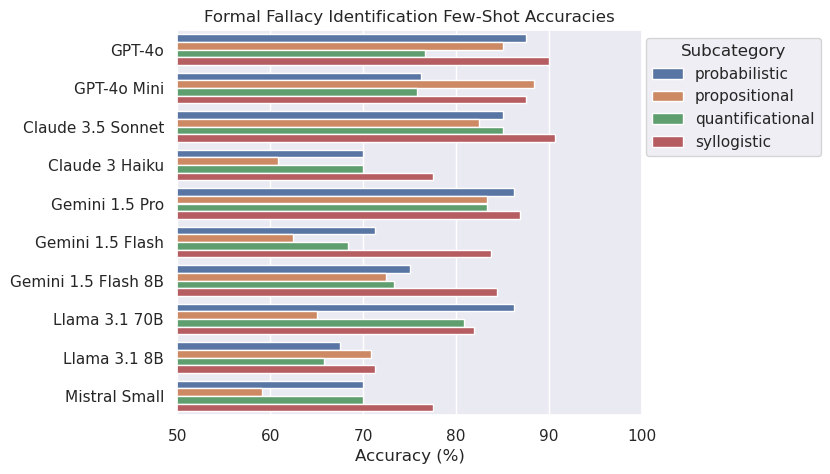

In [44]:
df_subcategory_accuracies_long_e2 = pd.melt(df_subcategory_accuracies_e2, value_name='accuracy', ignore_index=False)
df_formal_accuracies_long_e2 = df_subcategory_accuracies_long_e2[
    df_subcategory_accuracies_long_e2['category'] == 'formal']

plot_accuracies(
    data=add_llm_info(df_formal_accuracies_long_e2),
    figsize=(6, 5),
    title='Formal Fallacy Identification Few-Shot Accuracies',
    hue='subcategory',
    legend_title='Subcategory',
    legend_loc='upper right',
    legend_anchor=(1.4, 1),
    annotate=False,
    xlim=(50, 100),
)

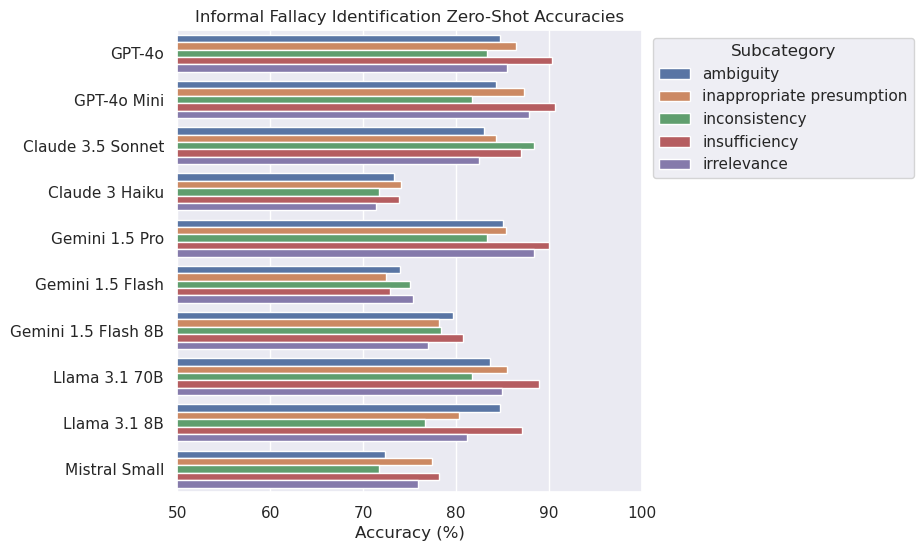

In [45]:
df_informal_accuracies_long_e2 = df_subcategory_accuracies_long_e2[
    df_subcategory_accuracies_long_e2['category'] == 'informal']

plot_accuracies(
    data=add_llm_info(df_informal_accuracies_long_e2),
    figsize=(6, 6),
    title='Informal Fallacy Identification Zero-Shot Accuracies',
    hue='subcategory',
    legend_title='Subcategory',
    legend_loc='upper right',
    legend_anchor=(1.6, 1),
    annotate=False,
    xlim=(50, 100),
)

## Experiment 3: Fallacy Identification with chain-of-thought Prompt

In [46]:
df_fallacies_e3 = get_fallacy_df('data/fallacies_e3.csv')

[2024-11-02 19:42:45] Loaded existing fallacy dataframe from data/fallacies_e3.csv.


### Scoring and Sanity Check

In [47]:
add_identification_scores(df_fallacies_e3)

df_fallacies_e3.head()

,step,entity,fallacy,label,category,subcategory,gpt_4o_response,claude_3_5_sonnet_response,gemini_1_5_pro_response,gpt_4o_mini_response,...,gemini_1_5_flash_8b_pred,gemini_1_5_flash_8b_score,llama_3_1_70b_pred,llama_3_1_70b_score,llama_3_1_8b_pred,llama_3_1_8b_score,mistral_large_2_pred,mistral_large_2_score,mistral_small_2_pred,mistral_small_2_score
0,Since John asked Maria if she used the last of...,tepas,Argument from Silence,1,informal,insufficiency,No. The reasoning step is not necessarily corr...,Let's think through this step-by-step: 1. Joh...,No. Silence is not necessarily an admission o...,No.,...,1,1,1,1,1,1,1,1,1,1
1,Since Alice asked if Bob knew what an 'ossia' ...,ossia,Argument from Silence,1,informal,insufficiency,No. The reasoning step is not correct. Bob's s...,Let's think through this step by step: 1. Ali...,No. Silence could indicate a lack of knowledg...,No.,...,1,1,1,1,1,1,1,1,1,1
2,Since Alice claims that the Hausdorff contents...,hausdorff contents,Argument from Silence,1,informal,insufficiency,No. The reasoning step is not correct. The con...,Let's think through this step-by-step: 1. Ali...,No. Bob's silence doesn't confirm Alice's cla...,No.,...,1,1,1,1,1,1,1,1,1,1
3,"Since Tom, a seasoned tugboater, said that ice...",tugboaters,Argument from Silence,1,informal,insufficiency,No. The reasoning step is not necessarily corr...,Let's think through this step-by-step: 1. The...,"No. While Tom's experience is valuable, the a...",No.,...,1,1,1,1,1,1,1,1,1,1
4,Since John accuses Mary of being terrified of ...,beewolf,Argument from Silence,1,informal,insufficiency,No. The reasoning step is not correct. The fac...,Let's think through this step-by-step: 1. Joh...,No. Silence does not imply guilt or fear. Ma...,No.,...,1,1,1,1,1,1,1,1,1,1


In [48]:
# Check completeness of responses, predictions and scores
df_fallacies_e3.replace(['', RESPONSE_ERROR], None).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4640 entries, 0 to 4639
Data columns (total 39 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   step                          4640 non-null   object  
 1   entity                        4640 non-null   object  
 2   fallacy                       4640 non-null   category
 3   label                         4640 non-null   category
 4   category                      4640 non-null   category
 5   subcategory                   4640 non-null   category
 6   gpt_4o_response               4640 non-null   object  
 7   claude_3_5_sonnet_response    4640 non-null   object  
 8   gemini_1_5_pro_response       4638 non-null   object  
 9   gpt_4o_mini_response          4640 non-null   object  
 10  claude_3_haiku_response       4640 non-null   object  
 11  gemini_1_5_flash_response     4639 non-null   object  
 12  gemini_1_5_flash_8b_response  4640 non-null   ob

In [49]:
get_sanity_check(df_fallacies_e3)

,response_length_mean,missing_responses,invalid_predictions
gpt_4o,340.4,0,32
claude_3_5_sonnet,1160.1,0,58
gemini_1_5_pro,199.4,2,26
gpt_4o_mini,5.9,0,0
claude_3_haiku,826.4,0,71
gemini_1_5_flash,245.0,1,6
gemini_1_5_flash_8b,222.8,0,0
llama_3_1_70b,904.7,0,149
llama_3_1_8b,757.9,0,19
mistral_large_2,373.2,0,9


- Chain of thought responses are longer and more complex. In a few cases, a clear Yes/No answer cannot be determined.
- GPT-4o Mini's low average response lenght indicates that it ignored the chain-of-thought instructions and just responded with Yes/No.

In [50]:
# Show invalid responses
df_fallacies_e3_invalid = df_fallacies_e3[df_fallacies_e3.isna().any(axis=1)]
df_fallacies_e3_invalid.head()

,step,entity,fallacy,label,category,subcategory,gpt_4o_response,claude_3_5_sonnet_response,gemini_1_5_pro_response,gpt_4o_mini_response,...,gemini_1_5_flash_8b_pred,gemini_1_5_flash_8b_score,llama_3_1_70b_pred,llama_3_1_70b_score,llama_3_1_8b_pred,llama_3_1_8b_score,mistral_large_2_pred,mistral_large_2_score,mistral_small_2_pred,mistral_small_2_score
16,Since Samantha claims that wheelbirds exist in...,wheelbirds,Argument from Silence,0,informal,insufficiency,Yes. The reasoning is correct. Samantha's clai...,Let's think through this step by step: 1. Sam...,"Yes. Samantha's claim without evidence, coupl...",Yes.,...,0,1,0,1,1,0,0,1,0,1
36,Since I declare that the city of Bergamo is th...,bergamo,Shifting of the Burden of Proof,0,informal,inappropriate presumption,Yes.,Let's break this down step by step: 1. The st...,Yes,Yes.,...,0,1,NaN,0,1,0,0,1,0,1
37,Since I claim that benzopyran has magical prop...,benzopyran,Shifting of the Burden of Proof,0,informal,inappropriate presumption,Yes. The reasoning step is correct. Claims abo...,Let's break this down step by step: 1. The st...,Yes,Yes.,...,0,1,NaN,0,1,0,0,1,0,1
57,Since seining is a traditional fishing method ...,seining,Political Correctness Fallacy,0,informal,irrelevance,Yes. The reasoning step acknowledges the cultu...,Let's break down this reasoning step by step: ...,Yes. The reasoning acknowledges the value of ...,Yes.,...,0,1,NaN,0,0,1,0,1,0,1
75,Since ghetto fences are either a symbol of sep...,ghetto fences,Affirming a Disjunct,0,formal,propositional,Yes. The reasoning is correct. The statement a...,Let's break this down step by step: 1. The st...,Yes. The premise states the fences can be *ei...,Yes.,...,0,1,NaN,0,0,1,0,1,1,0


### Global Accuracies

In [51]:
_, df_subcategory_accuracies_e3, df_category_accuracies_e3, df_global_accuracies_e3 = get_macro_accuracies(df_fallacies_e3)

In [52]:
df_global_accuracies_e3 = df_global_accuracies_e3.sort_values('accuracy', ascending=False)
df_global_accuracies_e3

,accuracy
gpt_4o,86.372656
gemini_1_5_pro,82.819718
gpt_4o_mini,81.568066
claude_3_5_sonnet,80.841547
llama_3_1_70b,80.500681
claude_3_haiku,79.89726
gemini_1_5_flash,79.845382
mistral_large_2,79.572555
gemini_1_5_flash_8b,77.709173
mistral_small_2,71.147021


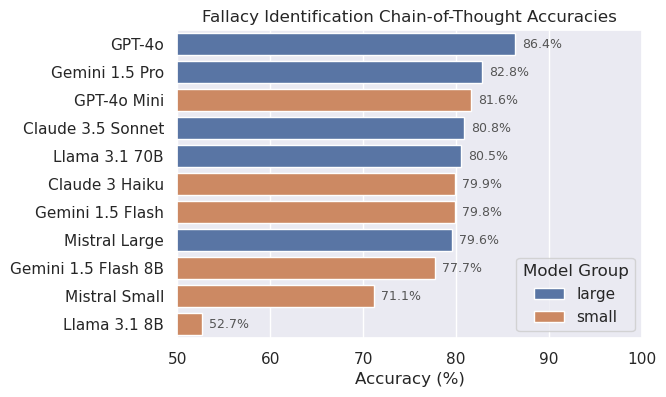

In [53]:
plot_accuracies(
    data=add_llm_info(df_global_accuracies_e3),
    figsize=(6, 4),
    title='Fallacy Identification Chain-of-Thought Accuracies',
    hue='llm_group',
    legend_title='Model Group',
    annotate=True,
    xlim=(50, 100),
)

### Fallacy Category Accuracies

In [54]:
df_category_accuracies_e3

category,formal,informal
gpt_4o,83.177083,89.568229
gpt_4o_mini,76.197917,86.938216
claude_3_5_sonnet,81.302083,80.38101
claude_3_haiku,73.541667,86.252854
gemini_1_5_pro,81.041667,84.59777
gemini_1_5_flash,80.260417,79.430347
gemini_1_5_flash_8b,75.3125,80.105845
llama_3_1_70b,78.385417,82.615945
llama_3_1_8b,49.947917,55.478014
mistral_large_2,77.760417,81.384694


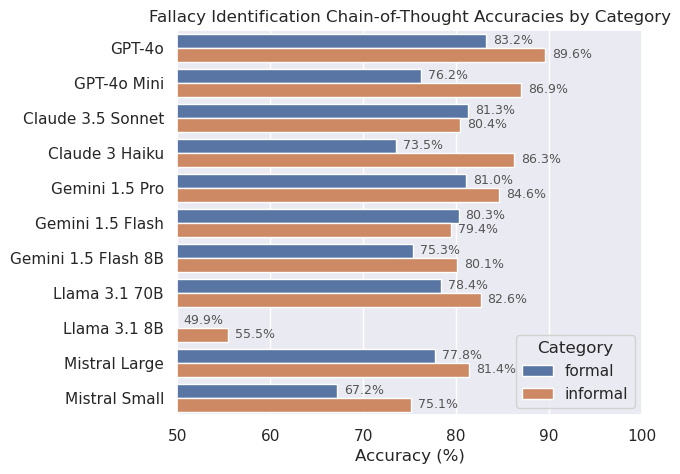

In [55]:
df_category_accuracies_long_e3 = pd.melt(df_category_accuracies_e3, var_name='category', value_name='accuracy',
                                         ignore_index=False)

plot_accuracies(
    data=add_llm_info(df_category_accuracies_long_e3),
    figsize=(6, 5),
    title='Fallacy Identification Chain-of-Thought Accuracies by Category',
    hue='category',
    legend_title='Category',
    annotate=True,
    xlim=(50, 100),
)

### Fallacy Subcategory Accuracies

In [56]:
df_subcategory_accuracies_e3

category                   formal                                             \
subcategory         probabilistic propositional quantificational syllogistic   
gpt_4o                       87.5     83.333333             82.5      79.375   
gpt_4o_mini                  77.5     74.166667             72.5      80.625   
claude_3_5_sonnet            85.0     90.833333             75.0      74.375   
claude_3_haiku               77.5     74.166667             72.5        70.0   
gemini_1_5_pro               82.5          87.5        79.166667        75.0   
gemini_1_5_flash             77.5     81.666667             77.5      84.375   
gemini_1_5_flash_8b         76.25     70.833333        74.166667        80.0   
llama_3_1_70b               81.25     86.666667             77.5      68.125   
llama_3_1_8b                51.25     50.833333        48.333333      49.375   
mistral_large_2              80.0          67.5        79.166667      84.375   
mistral_small_2             71.25          62.5             70.0        65.0   

category              informal                                          \
subcategory          ambiguity inappropriate presumption inconsistency   
gpt_4o               86.666667                 88.055556     91.666667   
gpt_4o_mini          83.666667                 87.962963     86.666667   
claude_3_5_sonnet    74.333333                 82.962963     81.666667   
claude_3_haiku       84.333333                 87.037037     86.666667   
gemini_1_5_pro       82.333333                 86.203704          80.0   
gemini_1_5_flash          80.0                  79.62963     81.666667   
gemini_1_5_flash_8b       78.0                 78.981481     83.333333   
llama_3_1_70b        80.666667                 84.444444     76.666667   
llama_3_1_8b              54.0                 56.944444          50.0   
mistral_large_2           81.0                 82.685185          80.0   
mistral_small_2           70.0                      77.5     73.333333   

category                                       
subcategory         insufficiency irrelevance  
gpt_4o                  92.413793   89.038462  
gpt_4o_mini             90.689655   85.705128  
claude_3_5_sonnet       84.224138   78.717949  
claude_3_haiku          87.586207   85.641026  
gemini_1_5_pro          88.362069   86.089744  
gemini_1_5_flash        80.086207   75.769231  
gemini_1_5_flash_8b     82.586207   77.628205  
llama_3_1_70b           87.327586   83.974359  
llama_3_1_8b            59.137931   57.307692  
mistral_large_2          83.87931   79.358974  
mistral_small_2         77.327586   77.371795

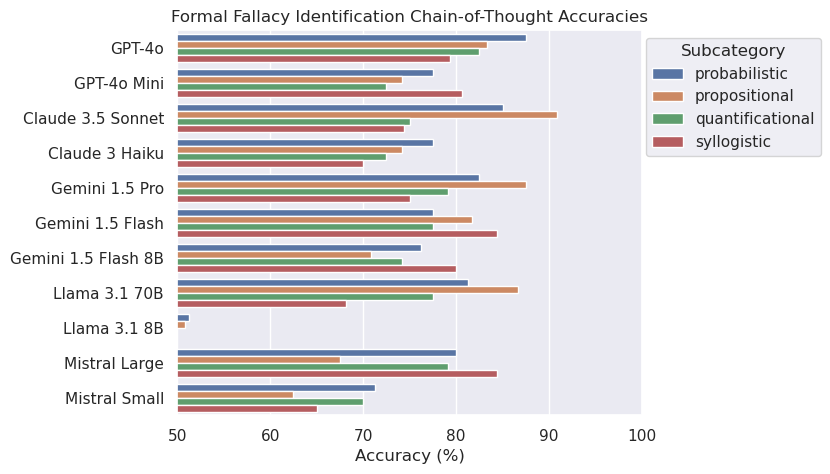

In [57]:
df_subcategory_accuracies_long_e3 = pd.melt(df_subcategory_accuracies_e3, value_name='accuracy', ignore_index=False)
df_formal_accuracies_long_e3 = df_subcategory_accuracies_long_e3[df_subcategory_accuracies_long_e3['category'] == 'formal']

plot_accuracies(
    data=add_llm_info(df_formal_accuracies_long_e3),
    figsize=(6, 5),
    title='Formal Fallacy Identification Chain-of-Thought Accuracies',
    hue='subcategory',
    legend_title='Subcategory',
    legend_loc='upper right',    
    legend_anchor=(1.4, 1),
    annotate=False,
    xlim=(50, 100),
)

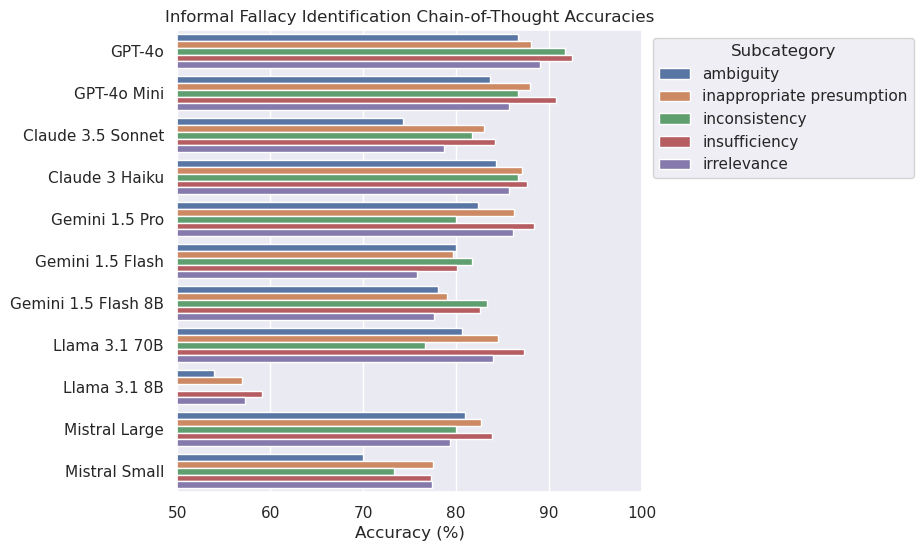

In [58]:
df_informal_accuracies_long_e3 = df_subcategory_accuracies_long_e3[df_subcategory_accuracies_long_e3['category'] == 'informal']

plot_accuracies(
    data=add_llm_info(df_informal_accuracies_long_e3),
    figsize=(6, 6),
    title='Informal Fallacy Identification Chain-of-Thought Accuracies',
    hue='subcategory',
    legend_title='Subcategory',
    legend_loc='upper right',
    legend_anchor=(1.6, 1),
    annotate=False,
    xlim=(50, 100),
)

### Confusion Analysis: Llama 3.1 8B

In [59]:
df_confusion_e3 = get_confusion_matrices(df_fallacies_e3, 'label')

In [60]:
df_confusion_metrics_llm_e3 = get_identification_confusion_metrics(df_confusion_e3, ['llm', 'label'])
df_confusion_metrics_llm_e3.round(3)


,TP,FN,FP,TN,Accuracy,Precision,Recall,F1,McNemar-P
llm,,,,,,,,,
claude_3_5_sonnet,2222,93,730,1537,0.820,0.753,0.960,0.844,0.000
claude_3_haiku,2094,205,417,1853,0.864,0.834,0.911,0.871,0.000
gemini_1_5_flash,2222,97,889,1426,0.787,0.714,0.958,0.818,0.000
gemini_1_5_flash_8b,2187,133,838,1482,0.791,0.723,0.943,0.818,0.000
gemini_1_5_pro,2153,167,467,1827,0.863,0.822,0.928,0.872,0.000
gpt_4o,2055,260,225,2068,0.895,0.901,0.888,0.894,0.123
gpt_4o_mini,2105,215,416,1904,0.864,0.835,0.907,0.870,0.000
llama_3_1_70b,2132,155,442,1762,0.867,0.828,0.932,0.877,0.000
llama_3_1_8b,2310,1,1994,316,0.568,0.537,1.000,0.698,0.000


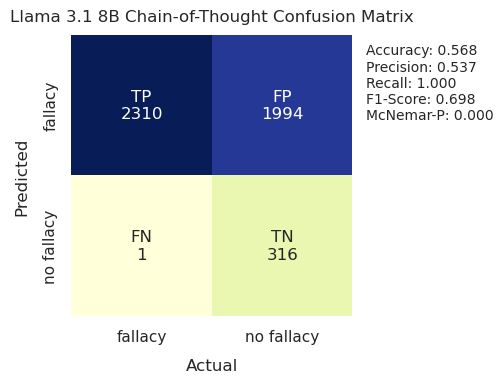

In [61]:
plot_identification_confusion_matrix(
    df_confusion_metrics_llm_e3.loc[LLM.LLAMA_3_1_8B.key], 
    title=f'{LLM.LLAMA_3_1_8B.label} Chain-of-Thought Confusion Matrix',
    figsize=(5, 4),
)

## Prompt Method Comparison

In [62]:
df_global_accuracies_e1['method'] = 'zero-shot'
df_global_accuracies_e2['method'] = 'few-shot'
df_global_accuracies_e3['method'] = 'chain-of-thought'
df_accuracies_methods = pd.concat([df_global_accuracies_e1, df_global_accuracies_e2, df_global_accuracies_e3])

# Select models which have been prompted with all methods
prompt_comparison_llms = [
    LLM.GPT_4O, LLM.GEMINI_1_5_PRO, LLM.CLAUDE_3_5_SONNET, LLM.MISTRAL_LARGE_2,
    LLM.GPT_4O_MINI, LLM.GEMINI_1_5_FLASH, LLM.GEMINI_1_5_FLASH_8B, LLM.CLAUDE_3_HAIKU, LLM.MISTRAL_SMALL_2
]

df_accuracies_methods = df_accuracies_methods.loc[[llm.key for llm in prompt_comparison_llms]]

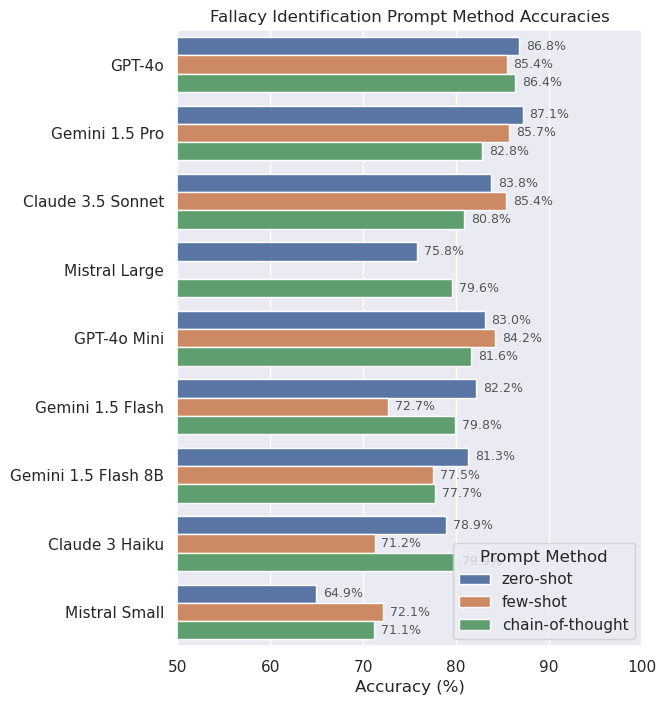

In [63]:
plot_accuracies(
    data=add_llm_info(df_accuracies_methods),
    figsize=(6, 8),
    title='Fallacy Identification Prompt Method Accuracies',
    hue='method',
    legend_title='Prompt Method',
    annotate=True,
    xlim=(50, 100),
)

In [64]:
df_plot = add_llm_info(df_accuracies_methods, group=True).groupby(['llm_group', 'method'], observed=True).mean().sort_values('method', ascending=False).reset_index()
df_plot

,llm_group,method,accuracy
0,large,zero-shot,83.376391
1,small,zero-shot,78.072561
2,large,few-shot,85.501119
3,small,few-shot,75.549421
4,large,chain-of-thought,82.401619
5,small,chain-of-thought,78.03338


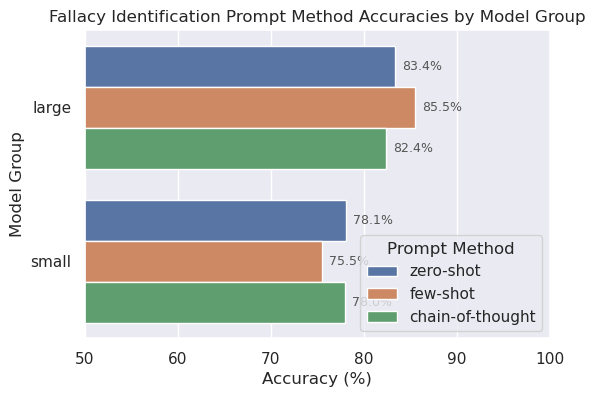

In [65]:
plot_accuracies(
    data=df_plot,
    figsize=(6, 4),
    title='Fallacy Identification Prompt Method Accuracies by Model Group',
    y='llm_group',
    y_label='Model Group',
    hue='method',
    order=[group.value for group in [LLMGroup.LARGE, LLMGroup.SMALL]],
    legend_title='Prompt Method',
    annotate=True,
    xlim=(50, 100),
)

- Few-shot and chain-of-thought prompts don't seem to improve the accuracies, compared to zero-shot prompts.
- Some of the small models seem to get confused by few-shot prompts sometimes, responding with "Yes No No Yes Yes".